<a href="https://www.kaggle.com/code/abhiii97/podcast-listen-time-prediction?scriptVersionId=233611131" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


## Step 1: Import Libraries

In [2]:
# Basic Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and Evaluation
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error



## Step 2: Load the Dataset

In [3]:

# Load the data
train = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')

In [4]:
## view the dataset
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [5]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [6]:
train.info

<bound method DataFrame.info of             id      Podcast_Name Episode_Title  Episode_Length_minutes  \
0            0   Mystery Matters    Episode 98                     NaN   
1            1     Joke Junction    Episode 26                  119.80   
2            2    Study Sessions    Episode 16                   73.90   
3            3    Digital Digest    Episode 45                   67.17   
4            4       Mind & Body    Episode 86                  110.51   
...        ...               ...           ...                     ...   
749995  749995      Learning Lab    Episode 25                   75.66   
749996  749996   Business Briefs    Episode 21                   75.75   
749997  749997  Lifestyle Lounge    Episode 51                   30.98   
749998  749998       Style Guide    Episode 47                  108.98   
749999  749999    Sports Central    Episode 99                   24.10   

             Genre  Host_Popularity_percentage Publication_Day  \
0       True 

In [7]:
train.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')

In [8]:
train.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

## Step 3: Data Cleaning & Preprocessing

In [9]:
# Drop columns that are not useful for modeling
train.drop(['id', 'Podcast_Name', 'Episode_Title'], axis=1, inplace=True)
test.drop(['id', 'Podcast_Name', 'Episode_Title'], axis=1, inplace=True)

In [10]:
# Convert string columns with numbers to float
train['Number_of_Ads'] = pd.to_numeric(train['Number_of_Ads'], errors='coerce')
test['Number_of_Ads'] = pd.to_numeric(test['Number_of_Ads'], errors='coerce')

In [11]:
# Fill missing values with median
train['Episode_Length_minutes'].fillna(train['Episode_Length_minutes'].median(), inplace=True)
train['Guest_Popularity_percentage'].fillna(train['Guest_Popularity_percentage'].median(), inplace=True)

test['Episode_Length_minutes'].fillna(test['Episode_Length_minutes'].median(), inplace=True)
test['Guest_Popularity_percentage'].fillna(test['Guest_Popularity_percentage'].median(), inplace=True)

In [12]:
# One-hot encode categorical features
train = pd.get_dummies(train, columns=['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment'], drop_first=True)
test = pd.get_dummies(test, columns=['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment'], drop_first=True)

In [13]:
# Align train and test columns
X = train.drop('Listening_Time_minutes', axis=1)
y = train['Listening_Time_minutes']
X, test = X.align(test, join='left', axis=1, fill_value=0)

In [14]:
from sklearn.impute import SimpleImputer

# Impute any remaining missing values with mean
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
test = pd.DataFrame(imputer.transform(test), columns=test.columns)


## Step 4: Feature Engineering

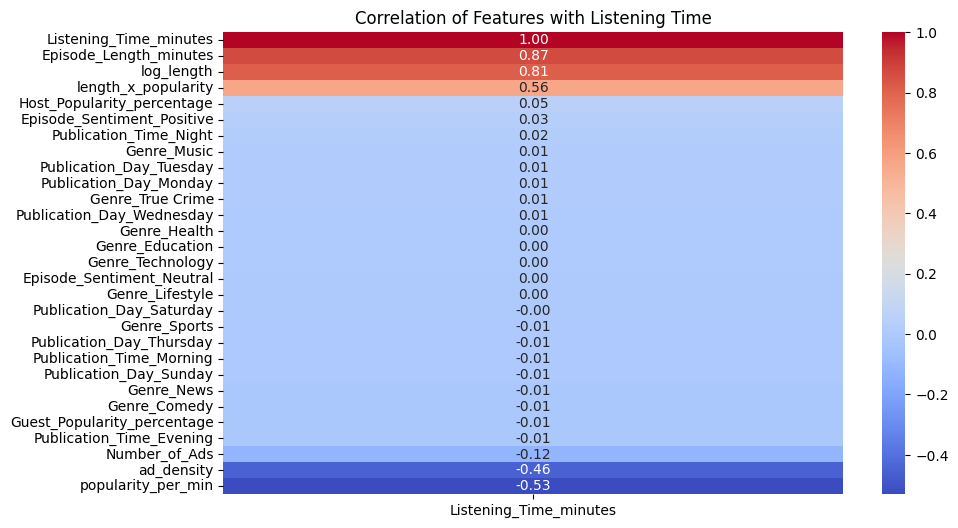

In [15]:
# Feature Engineering
X['ad_density'] = X['Number_of_Ads'] / (X['Episode_Length_minutes'] + 1)
X['length_x_popularity'] = X['Episode_Length_minutes'] * X['Guest_Popularity_percentage']
X['log_length'] = np.log1p(X['Episode_Length_minutes'])
X['popularity_per_min'] = X['Guest_Popularity_percentage'] / (X['Episode_Length_minutes'] + 1)

# Do same for test set
test['ad_density'] = test['Number_of_Ads'] / (test['Episode_Length_minutes'] + 1)
test['length_x_popularity'] = test['Episode_Length_minutes'] * test['Guest_Popularity_percentage']
test['log_length'] = np.log1p(test['Episode_Length_minutes'])
test['popularity_per_min'] = test['Guest_Popularity_percentage'] / (test['Episode_Length_minutes'] + 1)

# Correlation Heatmap

# Combine features and target for correlation
X_with_target = X.copy()
X_with_target['Listening_Time_minutes'] = y

# Compute correlations with target
correlation_with_target = X_with_target.corr()['Listening_Time_minutes'].sort_values(ascending=False)

# Display as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Listening Time")
plt.show()

## Step 5: Train XG Boost Model

In [16]:
# Model with improved parameters

from sklearn.model_selection import cross_val_score
model = XGBRegressor(
    n_estimators=2000,          # More trees, allows smaller learning rate
    learning_rate=0.04,        # Slower, more stable learning
    max_depth=9,                # Slightly shallower trees (avoids overfitting)
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.2,
    reg_alpha=0.5,              # More regularization
    reg_lambda=1.2,
    min_child_weight=5,
    random_state=42,
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)

# 5-fold Cross-Validation RMSE
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)
print("Average RMSE from 5-fold CV:", -np.mean(scores))


Average RMSE from 5-fold CV: 12.850006631542035


In [17]:
# Fit on full data now
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor', ...)

In [18]:
# predict on test set
test_pred = model.predict(test)

In [19]:
print(test_pred[:10])

[52.708817 19.081715 53.04761  75.25731  47.759487 21.98925  83.5148
 40.08359  62.60926  77.14436 ]


In [20]:
submission = sample_submission.copy()
submission['Listening_Time_minutes'] = test_pred
submission.to_csv('submission_xgb_tuned.csv', index=False)


In [21]:
submission.head()

,id,Listening_Time_minutes
0,750000,52.708817
1,750001,19.081715
2,750002,53.047611
3,750003,75.257309
4,750004,47.759487
